In [5]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [6]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/superResolution/maxGI'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')

In [10]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

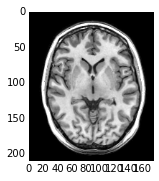

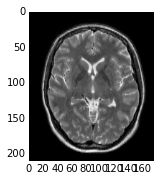

In [11]:
t1 = sitk.ReadImage(t1_fn)
t2 = sitk.ReadImage(t2_fn)

myshow(t1)
myshow(t2)

In [12]:
################################################################
# Now we find the gradient magnitude edge map from T1 and T2
# Such that we rescale the intensities of both image and pick the maximum value at each pixel
################################################################

MGI = GenerateSummedGradientImage() # Maximum Gradient Image
MGI.inputs.inputVolume1 = t1_fn
MGI.inputs.inputVolume2 = t2_fn
MGI.inputs.MaximumGradient = True
MGI.inputs.outputFileName = os.path.join(OutputDir,'MaximumGradientImage_ref.nii.gz')
print(MGI.cmdline)
MGI.run()

INFO:interface:stdout 2016-05-31T12:35:55.492691:Writing output ... 
INFO:interface:Could not get resources used by process. Error: (pid=84474)


 GenerateSummedGradientImage  --MaximumGradient  --inputVolume1 /scratch/TESTS/Aim2/Inputs/t1_average_BRAINSABC.nii.gz --inputVolume2 /scratch/TESTS/Aim2/Inputs/t2_average_BRAINSABC.nii.gz --outputFileName /scratch/TESTS/superResolution/maxGI/MaximumGradientImage_ref.nii.gz


In [33]:
outEdgeMap = os.path.join(OutputDir,'MaximumGradientImage_new.nii.gz')
BRIANSToolsPath = "/scratch/BS/release-BSR/bin"

!{BRIANSToolsPath}/BRAINSSuperResolution \
--inputMRVolumes {t1_fn},{t2_fn} \
--outputEdgeMap {outEdgeMap}

Reading image: /scratch/TESTS/Aim2/Inputs/t1_average_BRAINSABC.nii.gz
Reading image: /scratch/TESTS/Aim2/Inputs/t2_average_BRAINSABC.nii.gz
Generating maximum gradient edgemap took 1.27731 s.
ERROR:  Could not read image .


29.6791796797
29.6791796797


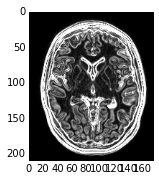

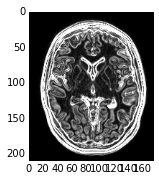

In [34]:
ref_maxGI = sitk.ReadImage(os.path.join(OutputDir,'MaximumGradientImage_ref.nii.gz'))
new_maxGI = sitk.ReadImage(os.path.join(OutputDir,'MaximumGradientImage_new.nii.gz'))

myshow(ref_maxGI)
myshow(new_maxGI)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(ref_maxGI)
print(totalStats.GetMean())

totalStats.Execute(new_maxGI)
print(totalStats.GetMean())

0.0
0.0


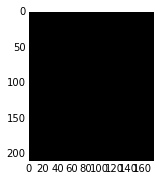

In [35]:
diff_image = abs(ref_maxGI-new_maxGI)
myshow(diff_image)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(diff_image)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())